---
# DN-compare

Here I compare the depth profiles before and after correcting the voxel selection. Doing so includes more subjects, but hopefully the results remain fairly similar

In [5]:
from linescanning import (
    utils,
    plotting,
    fitting,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import holeresponse as hr
opj = os.path.join
opd = os.path.dirname

## Read Data

In [2]:
# import subject dictionary containing useful information
subj_obj = hr.utils.SubjectsDict(proj_dir="/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC")
subj_obj.proj_dir

'/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC'

In [7]:
pkl_files = []

objs = {}
data_dir = opj(os.path.dirname(hr.viz._save_figure(None, return_figdir=True)), "data")
for tag,file in zip(["uncorr","corr"],["dn_full_sample","dn_full_sample_voxel_correction"]):
    objs[tag] = {}
    h5_pkl = opj(data_dir, f"{file}.pkl")
    print(f"{tag}: '{h5_pkl}'")
    with open(h5_pkl, 'rb') as handle:
        h5_obj = pickle.load(handle)

    objs[tag]["obj"] = h5_obj

uncorr: '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/dn_full_sample.pkl'
corr: '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/dn_full_sample_voxel_correction.pkl'


In [8]:
objs

{'uncorr': {'obj': <holeresponse.data.H5Parser at 0x7f6ae01b4370>},
 'corr': {'obj': <holeresponse.data.H5Parser at 0x7f6ad80a5fa0>}}

## Make epochs

In [13]:
for key,val in objs.items():
    comp_ep = fitting.Epoch(
        val["obj"].df_comps.groupby(["subject","task","t"]).mean(),
        hr.data.average_tasks(val["obj"].df_onsets),
        TR=0.105,
        interval=[-2,14]
    )

    comp = comp_ep.df_epoch.copy()
    val["comps"] = comp

## Plot

In [15]:
before_subjs = ["008","010","011","013","014","022"]
after_subjs = ["001","002","005","006","008","010","011","013","014","015","022"]

for ix,(key,val) in enumerate(objs.items()):
    val["subjects"] = [before_subjs,after_subjs][ix]

uncorr
 center (act)
 large annulus (suppr_2)
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles_cf_uncorr.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles_cf_uncorr.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles_cf_uncorr.svg'
corr
 center (act)
 large annulus (suppr_2)
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles_cf_corr.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles_cf_corr.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/group_desc-depth_imshow_profiles_cf_corr.svg'


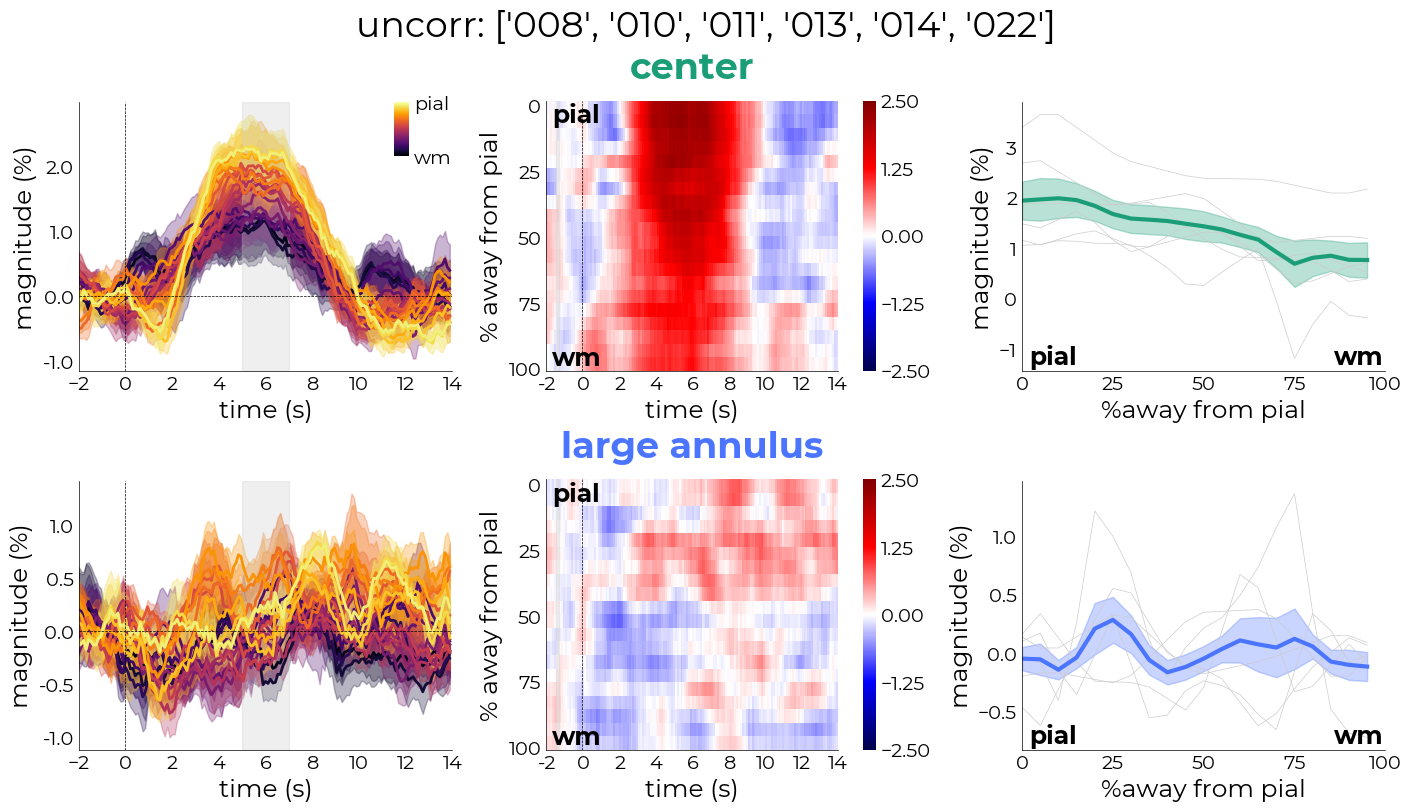

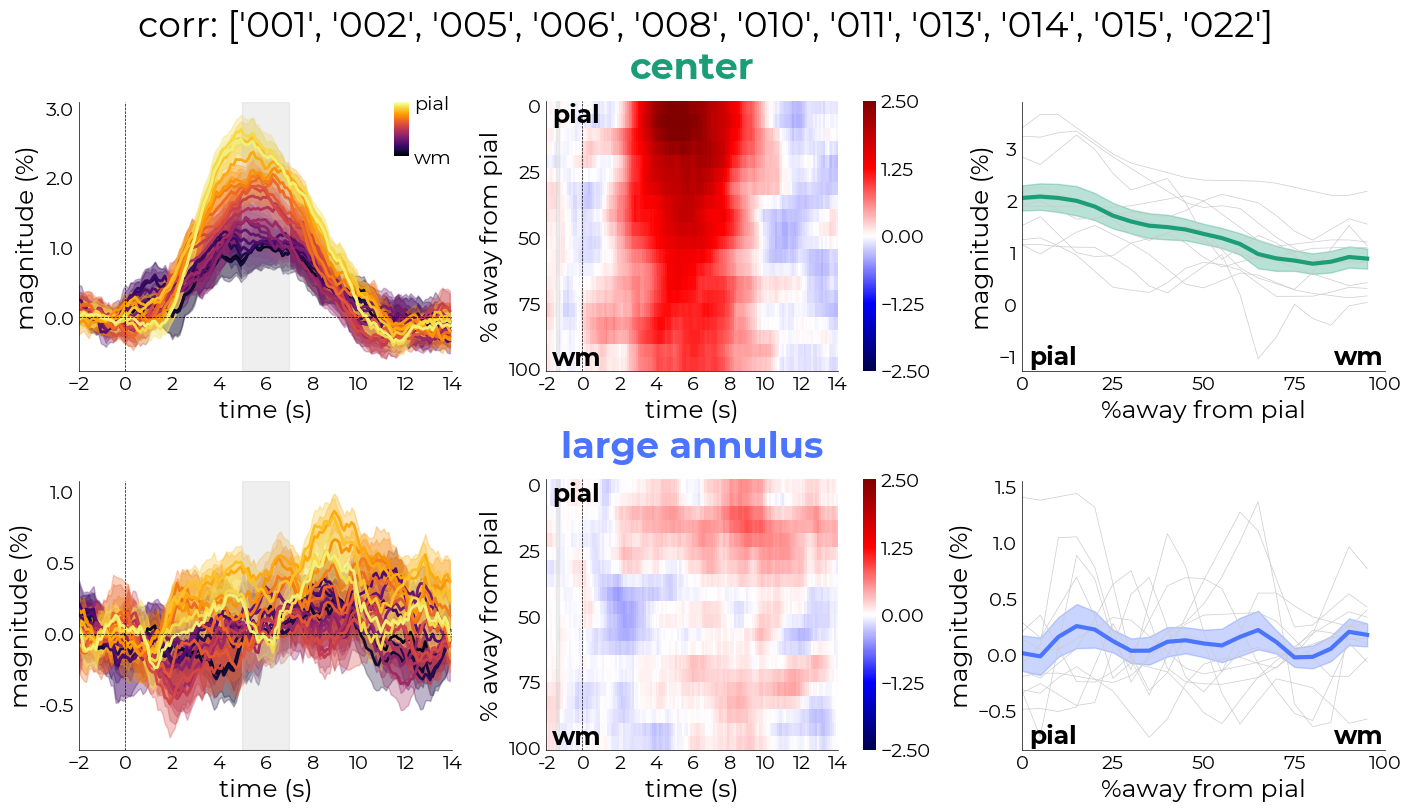

In [22]:
%matplotlib inline
for key,val in objs.items():

    print(key)
    
    df_comps = pd.concat([utils.select_from_df(val["comps"], expression=f"subject = {i}") for i in val["subjects"]])
    evs = utils.get_unique_ids(df_comps, id="event_type")

    incl_evs = [
        "center",
        "large annulus"
    ]

    ncols = 3
    fig = plt.figure(figsize=(14,len(incl_evs)*4), constrained_layout=True)
    sf = fig.subfigures(ncols=ncols)

    ref_data = df_comps.groupby(["subject","event_type","t"]).mean()
    interval = [5,7]
    time_df = utils.select_from_df(
        ref_data, 
        expression=(
            f"t > {interval[0]}",
            "&",
            f"t < {interval[1]}"
        )
    )

    time_avg = time_df.groupby(["subject","event_type"]).mean()

    tcs = {}
    # kws = {
    #     "gridspec_kw": {
    #         "hspace": 0.1
    #     }
    # }
    kws = {}

    ax_dict = {}
    for i in range(ncols):
        ax_dict[f"ax{i+1}"] = sf[i].subplots(nrows=len(incl_evs), **kws)

    in_data = df_comps.groupby(["event_type","t"]).mean()
    for ix,nn in enumerate(incl_evs):
        
        for k,v in ax_dict.items():
            if not isinstance(v, (list,np.ndarray)):
                ax_dict[k] = [v]

        ev = subj_obj.ev_mapper[nn]
        print(f" {nn} ({ev})")

        # fMRI 
        xy = hr.viz.XinYuPlot.single_xinyu_plot(
            utils.select_from_df(in_data, expression=f"event_type = {ev}"),
            axs=ax_dict["ax2"][ix],
            force_int=True,
            time_dec=0,
            time_ticks=9,
            depth_ticks=5,
            sns_kws={
                "vmin": -2.5,
                "vmax": 2.5
            },
            annot_color="k",
            contours=False,
            annot_onset=True,
            bsl=20
        )

        # stim onset
        hr.viz.add_axvspan(
            ax_dict["ax2"][ix],
            loc=interval
        )

        # Profiles
        if ix == 0:
            add_lbl = [f"{int(i)}%" for i in np.linspace(0,100,in_data.shape[0])]
        else:
            add_lbl = None
        
        grouper = utils.select_from_df(
            ref_data, 
            expression=f"event_type = {ev}"
        ).groupby(["t"])

        # get SEM from original inputs | profile list from "orig"-keys = shifted baseline
        sem_data = list(grouper.sem().values.T)
        prof_data = list(xy["orig"].values.T)

        # get time axis
        t_ = utils.get_unique_ids(ref_data, id="t")
        pl = plotting.LazyPlot(
            prof_data[::-1],
            xx=t_,
            x_ticks=np.arange(t_[0],t_[-1]*1.1, step=2),
            axs=ax_dict["ax1"][ix],
            cmap="inferno",
            add_hline=0,
            add_vline=0,
            x_label="time (s)",
            y_label="magnitude (%)",
            line_width=2,
            y_dec=1,
            error=sem_data
        )

        tcs[nn] = prof_data
        
        # make colorbar for depth
        if ix == 0:
            ax_inset = pl.axs.inset_axes([0.845,0.8,0.04,0.2])
            cb = plotting.LazyColorbar(
                cmap=pl.cmap,
                axs=ax_inset,
                cm_nr=2,
            )

            cb.axs.set_yticklabels(["wm","pial"])

        # stim onset
        hr.viz.add_axvspan(
            ax_dict["ax1"][ix],
            loc=interval
        )

        # Magnitude across depth

        tmp = utils.select_from_df(time_avg, expression=f"event_type = {ev}")
        # tmp = (tmp.T-tmp.mean(axis=1)).T
        # tmp = (tmp.T/tmp.max(axis=1)).T

        # tmp /= tmp.max().max()

        # plot subjects
        sub_ids = utils.get_unique_ids(tmp, id="subject")
        for sub in sub_ids:
            sub_vals = utils.select_from_df(tmp, expression=f"subject = {sub}").values
            plotting.LazyPlot(
                sub_vals,
                axs=ax_dict["ax3"][ix],
                line_width=0.5,
                color="#cccccc",
            )

        mean_ = tmp.mean().values
        err_ = tmp.sem().values
        ddict = hr.viz.make_wm_pial_ticks(mean_)
        pl = plotting.LazyPlot(
            mean_,
            axs=ax_dict["ax3"][ix],
            line_width=3,
            color=subj_obj.color_dict[nn],
            error=err_,
            x_ticks=ddict["ticks"],
            x_ticklabels=ddict["labels"],
            y_label="magnitude (%)",
            x_label="%away from pial",

        )

        hr.viz.annotate_cortical_ribbon(
            ax_dict["ax3"][ix],
            pial_pos=(0.02,0.025),
            wm_pos=(0.86,0.025),
            fontsize=pl.font_size,
            fontweight="bold"
        )
        
        # add white titles for other subfigures to maintain alignment
        for ax,tit,col in zip(
            [ax_dict["ax1"],ax_dict["ax2"],ax_dict["ax3"]],
            ["align",nn,"align"],
            ["white",subj_obj.color_dict[nn],"white"]
            ):

            ax[ix].set_title(
                tit, 
                fontsize=pl.title_size*1.1, 
                fontweight="bold",
                color=col,
                y=1.05
            )

    # save
    fig.suptitle(f"{key}: {val['subjects']}", fontsize=26)
    hr.viz._save_figure(
        fig, 
        fname=f"group_desc-depth_imshow_profiles_cf_{key}", 
        # overwrite=True
    )